In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def shift_and_append(df, n):

    # Shift the DataFrame by n positions (downward)
    shifted_df = df.shift(n)
    
    # Collect the dropped values (the last n rows before the shift)
    dropped_values = df.iloc[:-n].reset_index(drop=True)
    
    # Replace the first n rows (now NaN) with the dropped values
    shifted_df.iloc[n:] = dropped_values.values
    
    return shifted_df

In [3]:
def shift_and_concat(df, shifts):

    c = pd.DataFrame()
    noise = np.random.normal(0, 0.01, (df.shape[0]))
    
    for s in shifts:
        shifted_df = shift_and_append(df, s)
        shifted_df = shifted_df + noise
        c = pd.concat([c, shifted_df], axis=1)
        noise += np.random.normal(0, 0.01, (df.shape[0]))
    c.columns = [f'{df.name}_{abs(s)}h' for s in shifts]
    return c

In [4]:
def generate_data(
    solar_profile
):
    
    sol = {
        'load': 0.6 * solar_profile,
        'batt': 0.4 * solar_profile,
        'action': 0.4 * solar_profile,
        'soc': np.zeros(24)
    }

    ix_last_gen = len(solar_profile)

    for gen in reversed(solar_profile):

        if gen > 0:
            break
        
        ix_last_gen -= 1

    # Adjust action to the last generation

    capacity = np.sum(sol['batt'])

    sol['load'][ix_last_gen] = capacity
    sol['batt'][ix_last_gen] = - capacity
    sol['action'][ix_last_gen] = - capacity

    # Adjust action according to capacity

    sol['action'] /= capacity

    # Create SoC by doing the cumulative sum of the action

    sol['soc'] = np.cumsum(sol['action'])
    
    return sol, capacity

In [5]:
def generate_data(
    solar_profile, batt_cap, load_ratio: float = 0.6
):
    
    batt_ratio = 1 - load_ratio
    
    sol = {
        'load': np.zeros(24),
        'batt': np.zeros(24),
        'action': np.zeros(24),
    }

    # Load and charge generation profiles

    stored = 0
    residual = 0

    for h, gen in enumerate(solar_profile):

        add_load = 0
    
        if stored < batt_cap:
            to_store = min(batt_ratio * gen, batt_cap - stored)
            residual = max(0, batt_ratio * gen - to_store)
        else:
            residual = 0
            to_store = - np.random.uniform(0, 0.5) * stored
            add_load = batt_ratio * gen - to_store

        sol['load'][h] += load_ratio * gen + residual + add_load
        sol['batt'][h] += to_store

        stored += to_store

    # Find index of last generation timestep

    ix_last_gen = len(solar_profile)

    for gen in reversed(solar_profile):

        if gen > 0:
            break
        
        ix_last_gen -= 1

    # Adjust action to the last generation

    sol['load'][ix_last_gen] = stored
    sol['batt'][ix_last_gen] = - stored
    sol['action'] = sol['batt']
    sol['action'][ix_last_gen] = - stored

    # Adjust action according to capacity

    sol['action'] /= batt_cap

    # Create SoC by doing the cumulative sum of the action

    sol['soc'] = np.cumsum(sol['action'])
    
    return sol

In [4]:
def generate_data(
    solar_profile, batt_cap, load_ratio: float = 0.6
):
    
    batt_ratio = 1 - load_ratio
    
    sol = {
        'load': np.zeros(24),
        'batt': np.zeros(24),
        'action': np.zeros(24),
    }

    # Load and charge generation profiles

    stored = 0
    residual = 0

    for h, gen in enumerate(solar_profile):

        to_store = min(batt_ratio * gen, batt_cap - stored)
        residual = max(0, batt_ratio * gen - to_store)

        sol['load'][h] += load_ratio * gen + residual
        sol['batt'][h] += to_store

        stored += to_store

    # Find index of last generation timestep

    ix_last_gen = next((i for i, gen in enumerate(reversed(solar_profile)) if gen > 0), 0)
    ix_last_gen = len(solar_profile) - ix_last_gen

    # Distribute the stored energy unirmly over the last steps after the last generation

    steps = len(solar_profile) - ix_last_gen
    stored_per_step = stored / steps

    for h in range(ix_last_gen, len(solar_profile)):

        sol['load'][h] += stored_per_step
        sol['batt'][h] -= stored_per_step

    # Adjust action according to capacity

    sol['action'] = sol['batt']
    sol['action'] /= batt_cap

    # Create SoC by doing the cumulative sum of the action

    sol['soc'] = np.cumsum(sol['action'])
    
    return sol

In [5]:
def plot_energy_solution(sol, solar_generation):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
    ax1.plot(sol['load'], label='Load', marker='o')
    ax1.plot(sol['batt'], label='Battery energy', color='g', linestyle='--', marker='o')
    ax1.plot(solar_generation, label='Solar generation', marker='o')
    ax1.plot(sol['load'] + sol['batt'] - solar_generation, label='Total energy', color='m', linestyle='--', marker='o')

    ax2.plot(sol['soc'], label='State of charge', color='tab:red', marker='o')
    ax2.plot(sol['action'], label='Battery action', color='tab:purple', marker='o')

    ax1.set_xlabel('Time (hours)')
    ax2.set_xlabel('Time (hours)')
    ax1.set_ylabel('Energy (kWh)')
    ax2.set_ylabel('State of Charge')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax1.grid()
    ax2.grid()

    ax1.set_xticks(range(0, 24))
    ax2.set_xticks(range(0, 24))

    plt.show()

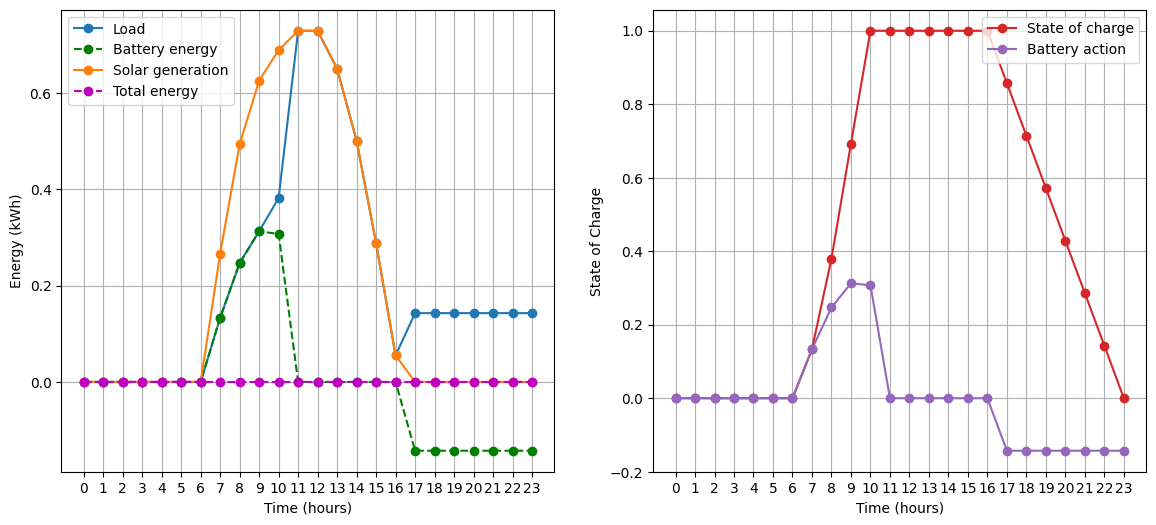

In [6]:
# Define solar energy generation values (in kWh) for each hour

# solar_generation = np.array([0, 0, 0, 0, 0, 0, 0, 0.5, 1.5, 3.0, 4.5, 5.0, 4.8, 4.0, 3.0, 1.5, 0.5, 0.1, 0, 0, 0, 0, 0, 0]) * 200

# solar_generation = np.array([  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
#           0.     ,  13.82083,  58.45417,  91.12083, 103.21667,  90.8125 ,
#          96.45834, 239.975  , 162.25833, 415.49167, 294.30417, 153.09166,
#          17.27917,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ])

# solar_generation = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
#        0.        , 0.        , 0.01382083, 0.05845417, 0.09112083,
#        0.10321667, 0.0908125 , 0.09645834, 0.239975  , 0.16225833,
#        0.41549167, 0.29430417, 0.15309166, 0.01727917, 0.        ,
#        0.        , 0.        , 0.        , 0.        ])

solar_generation = np.array([
    0.        , 0.        , 0.        , 0.        , 0.        ,
    0.        , 0.01450417, 0.11152084, 0.27647083, 0.453025  ,
    0.6069625 , 0.71275   , 0.759825  , 0.7512625 , 0.689675  ,
    0.581275  , 0.422425  , 0.2426    , 0.08224167, 0.00623333,
    0.        , 0.        , 0.        , 0.        
])

solar_generation = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.26625833, 0.49377917, 0.6256    ,
       0.68894165, 0.72923334, 0.72894586, 0.6503542 , 0.50075418,
       0.2881125 , 0.05493333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]
)

# solar_generation = np.where(solar_generation > 0, 1.0, solar_generation)

# solar_generation /= 1000

# Define an assignation of energy consumption by levels

# sol, batt_cap = generate_data(solar_profile=solar_generation)
sol = generate_data(solar_profile=solar_generation, batt_cap=1, load_ratio=0.5)
plot_energy_solution(sol, solar_generation)

In [ ]:
import os
import json
import shutil

import numpy as np
import pandas as pd
from tqdm import tqdm

from pathlib import Path
from citylearn.data import DataSet

def generate_naive_data_from_ref(
    base_dataset: str = 'citylearn_challenge_2022_phase_all', dest_folder: str = 'data/naive_data/', building_no: int = 5,
):

    # If the directory exists, delete it and create the subfolders
    
    shutil.rmtree(dest_folder, ignore_errors=True)
    
    # Creat destination folder exists including the subfolders

    Path(dest_folder).mkdir(parents=True, exist_ok=True)

    # Get reference schema

    schema = DataSet.get_schema(base_dataset)

    # Reduce the number of buildings to 1

    schema['buildings'] = {f'Building_{i + 1}': schema['buildings'][f'Building_{i + 1}'] for i in range(building_no)}

    # Extract the base weather, emissions and pricing data (doesn't change among buildings)

    base_weather = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['weather']))
    base_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))
    base_emissions = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['carbon_intensity']))

    # Read the base schema and process the json

    # We need just to store the load and optimal actions for each building
    # 0 - Load
    # 1 - Battery charge/discharge energy

    building_data = np.array([[[0.] * 2 for _ in range(365 * 24)] for _ in range(building_no)])
    batt_caps = [0.0] * building_no
    base_csvs = []

    for building_no, (building_name, info) in enumerate(schema['buildings'].items()):

        # Create custom building CSVs

        base_csv = pd.read_csv(os.path.join(schema['root_directory'], info['energy_simulation']))
        solar_generation = base_csv['solar_generation'].values / 1000
        base_csvs.append(base_csv)

        # Pass one day at a time the solar generation from the building data

        with tqdm(total=365, desc=f'Processing Building {building_no + 1}') as pbar:

            for day in range(365):

                sol, batt_cap = generate_data(
                    solar_profile=solar_generation[day * 24:(day + 1) * 24],
                )

                building_data[building_no, day * 24:(day + 1) * 24, 0] += sol['load']
                building_data[building_no, day * 24:(day + 1) * 24, 1] += sol['batt']

                batt_caps[building_no] = max(batt_cap, batt_caps[building_no])

                pbar.set_postfix({'building': building_name, 'day': day})

                pbar.update(1)

    # Update the base csv with the new data

    for building_no, (building_name, _) in enumerate(schema['buildings'].items()):

        base_csvs[building_no]['non_shiftable_load'] = building_data[building_no,:,0].clip(min=0)
        base_csvs[building_no].to_csv(os.path.join(dest_folder, f'{building_name}.csv'), index=False)

        # Save batt action and soc in a separate file to avoid issues loading CityLearn

        sol_csv = pd.DataFrame(columns=['batt', 'soc'], index=range(365 * 24))

        sol_csv['batt'] = building_data[building_no,:,1]
        sol_csv['action'] = sol_csv['batt'] / batt_caps[building_no]
        sol_csv['soc'] = np.cumsum(sol_csv['action'])

        sol_csv.to_csv(os.path.join(dest_folder, f'sol_{building_name}.csv'), index=False)

        # Save predictions (synthetic) for the building

        shifts = [-4, -6, -12, -24] # 4, 6, 12, 24 hours in the future

        shift_and_concat(
            df=base_csvs[building_no]['non_shiftable_load'],
            shifts=shifts
        ).clip(lower=0).to_csv(os.path.join(dest_folder, f'pred_{building_name}.csv'), index=False)

        # Update the schema with the new paths

        schema['buildings'][building_name]['energy_simulation'] = f'{building_name}.csv'

        # Update the schema to guarantee an ideal battery

        schema['buildings'][building_name]['electrical_storage']['attributes'] = {
            "capacity": batt_caps[building_no],
            "efficiency": 1.0,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": batt_caps[building_no],
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

        # Set nominal power to 1 for solar panel to simplify case

        schema['buildings'][building_name]['pv']['attributes']['nominal_power'] = 1.0

    # Write pricing and emissions data to the destination folder

    base_weather.to_csv(os.path.join(dest_folder, 'weather.csv'), index=False)
    base_pricing.to_csv(os.path.join(dest_folder, 'pricing.csv'), index=False)
    base_emissions.to_csv(os.path.join(dest_folder, 'carbon_intensity.csv'), index=False)

    # Save the new schema in the destination folder

    schema['root_directory'] = dest_folder

    with open(os.path.join(dest_folder, 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)


In [ ]:
import os
import json
import shutil

import numpy as np
import pandas as pd
from tqdm import tqdm

from pathlib import Path
from citylearn.data import DataSet

def generate_naive_data_from_ref(
    base_dataset: str = 'citylearn_challenge_2022_phase_all', dest_folder: str = 'data/naive_data/', building_no: int = 5, batt_cap: float = 1.0
):

    # If the directory exists, delete it and create the subfolders
    
    shutil.rmtree(dest_folder, ignore_errors=True)
    
    # Creat destination folder exists including the subfolders

    Path(dest_folder).mkdir(parents=True, exist_ok=True)

    # Get reference schema

    schema = DataSet.get_schema(base_dataset)

    # Reduce the number of buildings to 1

    schema['buildings'] = {f'Building_{i + 1}': schema['buildings'][f'Building_{i + 1}'] for i in range(building_no)}

    # Extract the base weather, emissions and pricing data (doesn't change among buildings)

    base_weather = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['weather']))
    base_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))
    base_emissions = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['carbon_intensity']))

    # Read the base schema and process the json

    # We need just to store the load and optimal actions for each building
    # 0 - Load
    # 1 - Battery charge/discharge energy
    # 2 - SoC
    # 3 - Action

    building_data = np.array([[[0.] * 4 for _ in range(365 * 24)] for _ in range(building_no)])
    base_csvs = []

    for building_no, (building_name, info) in enumerate(schema['buildings'].items()):

        # Create custom building CSVs

        base_csv = pd.read_csv(os.path.join(schema['root_directory'], info['energy_simulation']))
        solar_generation = base_csv['solar_generation'].values / 1000
        base_csvs.append(base_csv)

        # Pass one day at a time the solar generation from the building data

        with tqdm(total=365, desc=f'Processing Building {building_no + 1}') as pbar:

            for day in range(365):

                sol = generate_data(
                    solar_profile=solar_generation[day * 24:(day + 1) * 24], batt_cap=batt_cap
                )

                building_data[building_no, day * 24:(day + 1) * 24, 0] += sol['load']
                building_data[building_no, day * 24:(day + 1) * 24, 1] += sol['batt']
                building_data[building_no, day * 24:(day + 1) * 24, 2] += sol['soc']
                building_data[building_no, day * 24:(day + 1) * 24, 3] += sol['action']

                pbar.set_postfix({'building': building_name, 'day': day})

                pbar.update(1)

    # Update the base csv with the new data

    for building_no, (building_name, _) in enumerate(schema['buildings'].items()):

        base_csvs[building_no]['non_shiftable_load'] = building_data[building_no,:,0].clip(min=0)
        base_csvs[building_no].to_csv(os.path.join(dest_folder, f'{building_name}.csv'), index=False)

        # Save batt action and soc in a separate file to avoid issues loading CityLearn

        sol_csv = pd.DataFrame(columns=['batt', 'soc'], index=range(365 * 24))

        sol_csv['batt'] = building_data[building_no,:,1]
        sol_csv['soc'] = building_data[building_no,:,2]
        sol_csv['action'] = building_data[building_no,:,3]

        sol_csv.to_csv(os.path.join(dest_folder, f'sol_{building_name}.csv'), index=False)

        # Save predictions (synthetic) for the building

        shifts = [-4, -6, -12, -24] # 4, 6, 12, 24 hours in the future

        shift_and_concat(
            df=base_csvs[building_no]['non_shiftable_load'],
            shifts=shifts
        ).clip(lower=0).to_csv(os.path.join(dest_folder, f'pred_{building_name}.csv'), index=False)

        # Update the schema with the new paths

        schema['buildings'][building_name]['energy_simulation'] = f'{building_name}.csv'

        # Update the schema to guarantee an ideal battery

        schema['buildings'][building_name]['electrical_storage']['attributes'] = {
            "capacity": batt_cap,
            "efficiency": 1.0,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": batt_cap,
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

        # Set nominal power to 1 for solar panel to simplify case

        schema['buildings'][building_name]['pv']['attributes']['nominal_power'] = 1.0

    # Write pricing and emissions data to the destination folder

    base_weather.to_csv(os.path.join(dest_folder, 'weather.csv'), index=False)
    base_pricing.to_csv(os.path.join(dest_folder, 'pricing.csv'), index=False)
    base_emissions.to_csv(os.path.join(dest_folder, 'carbon_intensity.csv'), index=False)

    # Save the new schema in the destination folder

    schema['root_directory'] = dest_folder

    with open(os.path.join(dest_folder, 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)


In [7]:
import os
import json
import shutil

import numpy as np
import pandas as pd
from tqdm import tqdm

from pathlib import Path
from citylearn.data import DataSet

def generate_naive_data_from_ref(
    base_dataset: str = 'citylearn_challenge_2022_phase_all', dest_folder: str = 'data/naive_data/', building_no: int = 5, batt_cap: float = 1.0,
    load_ratio: float = 0.6
):

    # If the directory exists, delete it and create the subfolders
    
    shutil.rmtree(dest_folder, ignore_errors=True)
    
    # Creat destination folder exists including the subfolders

    Path(dest_folder).mkdir(parents=True, exist_ok=True)

    # Get reference schema

    schema = DataSet.get_schema(base_dataset)

    # Reduce the number of buildings to 1

    schema['buildings'] = {f'Building_{i + 1}': schema['buildings'][f'Building_{i + 1}'] for i in range(building_no)}

    # Extract the base weather, emissions and pricing data (doesn't change among buildings)

    base_weather = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['weather']))
    base_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))
    base_emissions = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['carbon_intensity']))

    # Read the base schema and process the json

    # We need just to store the load and optimal actions for each building
    # 0 - Load
    # 1 - Battery charge/discharge energy
    # 2 - SoC
    # 3 - Action

    building_data = np.array([[[0.] * 4 for _ in range(365 * 24)] for _ in range(building_no)])
    base_csvs = []

    for building_no, (building_name, info) in enumerate(schema['buildings'].items()):

        # Create custom building CSVs

        base_csv = pd.read_csv(os.path.join(schema['root_directory'], info['energy_simulation']))
        solar_generation = base_csv['solar_generation'].values / 1000
        base_csvs.append(base_csv)

        # Pass one day at a time the solar generation from the building data

        with tqdm(total=365, desc=f'Processing Building {building_no + 1}') as pbar:

            for day in range(365):

                solar_profile = solar_generation[day * 24:(day + 1) * 24]
                # solar_profile = np.where(solar_profile > 0, solar_profile.max(), solar_profile)
                # base_csv.loc[day * 24:(day + 1) * 24 - 1, 'solar_generation'] = base_csv['solar_generation'][
                #     day * 24:(day + 1) * 24
                # ].apply(lambda x: 0 if x == 0 else solar_profile.max()) * 1000
                
                sol = generate_data(
                    solar_profile=solar_profile, batt_cap=batt_cap, load_ratio=load_ratio
                )

                building_data[building_no, day * 24:(day + 1) * 24, 0] += sol['load']
                building_data[building_no, day * 24:(day + 1) * 24, 1] += sol['batt']
                building_data[building_no, day * 24:(day + 1) * 24, 2] += sol['soc']
                building_data[building_no, day * 24:(day + 1) * 24, 3] += sol['action']

                pbar.set_postfix({'building': building_name, 'day': day})

                pbar.update(1)

    # Update the base csv with the new data

    for building_no, (building_name, _) in enumerate(schema['buildings'].items()):

        base_csvs[building_no]['non_shiftable_load'] = building_data[building_no,:,0].clip(min=0)
        base_csvs[building_no].to_csv(os.path.join(dest_folder, f'{building_name}.csv'), index=False)

        # Save batt action and soc in a separate file to avoid issues loading CityLearn

        sol_csv = pd.DataFrame(columns=['batt', 'soc'], index=range(365 * 24))

        sol_csv['batt'] = building_data[building_no,:,1]
        sol_csv['soc'] = building_data[building_no,:,2]
        sol_csv['action'] = building_data[building_no,:,3]

        sol_csv.to_csv(os.path.join(dest_folder, f'sol_{building_name}.csv'), index=False)

        # Save predictions (synthetic) for the building

        shifts = [-4, -6, -12, -24] # 4, 6, 12, 24 hours in the future

        shift_and_concat(
            df=base_csvs[building_no]['non_shiftable_load'],
            shifts=shifts
        ).clip(lower=0).to_csv(os.path.join(dest_folder, f'pred_{building_name}.csv'), index=False)

        # Update the schema with the new paths

        schema['buildings'][building_name]['energy_simulation'] = f'{building_name}.csv'

        # Update the schema to guarantee an ideal battery

        schema['buildings'][building_name]['electrical_storage']['attributes'] = {
            "capacity": batt_cap,
            "efficiency": 1.0,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": batt_cap,
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

        # Set nominal power to 1 for solar panel to simplify case

        schema['buildings'][building_name]['pv']['attributes']['nominal_power'] = 1.0

    # Write pricing and emissions data to the destination folder

    base_weather.to_csv(os.path.join(dest_folder, 'weather.csv'), index=False)
    base_pricing.to_csv(os.path.join(dest_folder, 'pricing.csv'), index=False)
    base_emissions.to_csv(os.path.join(dest_folder, 'carbon_intensity.csv'), index=False)

    # Save the new schema in the destination folder

    schema['root_directory'] = dest_folder

    with open(os.path.join(dest_folder, 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)


In [10]:
# Define an assignation of energy consumption by levels

dest_folder='data/less_naive_data/'

generate_naive_data_from_ref(
    building_no=2, batt_cap=1.0, load_ratio=0.5, dest_folder=dest_folder
)

Processing Building 2: 100%|██████████| 365/365 [00:00<00:00, 832.17it/s, building=Building_2, day=364]


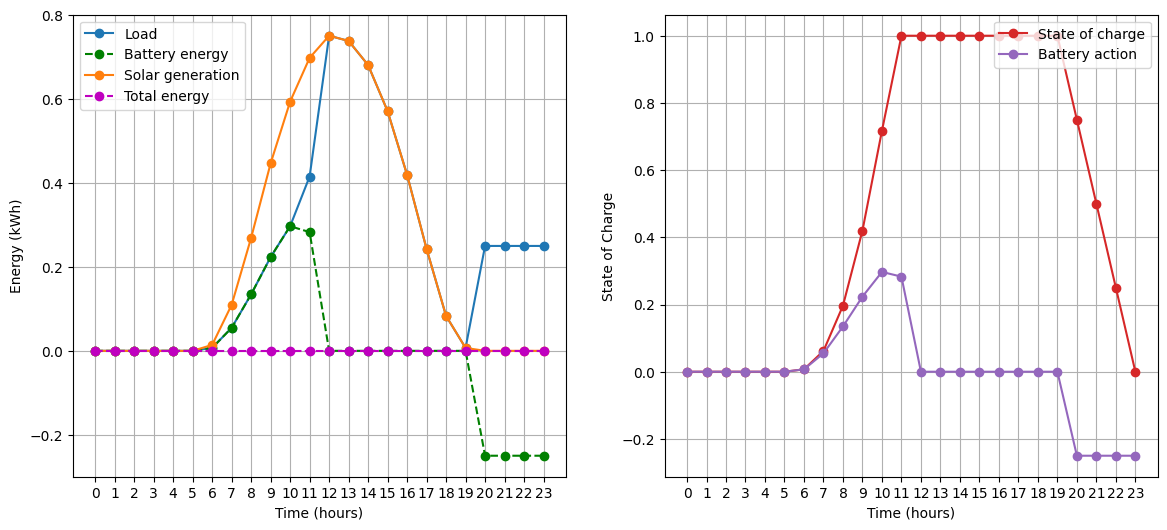

In [13]:
# Check data generated picking random days from random buildings

day_index = 24#24 * 150
building_index = 0

with open(f'{dest_folder}schema.json', 'r') as f:
    schema = json.load(f)

building_name = f'Building_{building_index + 1}'
building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

solar_generation = building_csv['solar_generation'].values / 1000
load = building_csv['non_shiftable_load'].values
batt = sol_csv['batt'].values
soc = sol_csv['soc'].values
action = sol_csv['action'].values
battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

plot_energy_solution({
    'load': load[day_index:day_index + 24],
    'action': action[day_index:day_index + 24],
    'batt': batt[day_index:day_index + 24],
    'soc': soc[day_index:day_index + 24]
}, solar_generation[day_index:day_index + 24])

In [77]:
# Check net energy of whole year

with open('data/naive_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values / 1000
    load = building_csv['non_shiftable_load'].values
    batt = sol_csv['batt'].values
    soc = sol_csv['soc'].values
    
    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values
    
    cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).sum()
    cost = (net_energy.clip(min=0) * pricing + net_energy.clip(max=0) * 0.9 * pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

Building 1
Avg. Hour Cost No batt: 50.6598753327777 - With batt: -8.661629573303298e-15
Avg. Hour Emissions No batt: 58.9247541911663 - With batt: 4.2512059116039944e-16
Building 2
Avg. Hour Cost No batt: 50.24434777479259 - With batt: -1.3016428755154018e-14
Avg. Hour Emissions No batt: 58.400386786569044 - With batt: 0.0


In [11]:
# Check net energy for a given period

day_index = 888

with open('data/naive_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    
    cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).sum()
    cost = (net_energy.clip(min=0) * pricing).sum() + (net_energy.clip(max=0) * 0.9 * pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

Building 1
Avg. Hour Cost No batt: 0.15000000000000005 - With batt: -5.495603971894525e-18
Avg. Hour Emissions No batt: 0.154700218 - With batt: 0.0
Building 2
Avg. Hour Cost No batt: 0.15000000000000002 - With batt: 0.0
Avg. Hour Emissions No batt: 0.154700218 - With batt: 0.0


In [81]:
# Check net energy for a given period

day_index = 5832

with open('data/naive_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    
    cost_no_batt = (net_energy_no_batt * pricing).sum()
    cost = (net_energy * pricing).sum()

    # Correct energy cost

    correct_cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).sum()
    correct_cost = (net_energy.clip(min=0) * pricing + net_energy.clip(max=0) * 0.9 * pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Correct Cost No batt: {correct_cost_no_batt} - With batt: {correct_cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

Building 1
Avg. Hour Cost No batt: 0.11600000000000002 - With batt: -5.828670879282072e-18
Avg. Hour Correct Cost No batt: 0.137 - With batt: -5.245803791353865e-18
Avg. Hour Emissions No batt: 0.16594390000000003 - With batt: 0.0
Building 2
Avg. Hour Cost No batt: 0.11600000000000002 - With batt: -1.1657341758564143e-17
Avg. Hour Correct Cost No batt: 0.137 - With batt: -1.049160758270773e-17
Avg. Hour Emissions No batt: 0.16594390000000003 - With batt: 0.0


# Validation data from convex combination of houses

In [82]:
def convex_combination_of_df(df1, df2, alpha):

    comb = df1 * alpha + df2 * (1 - alpha)
    comb = comb.astype(df1.dtypes)

    return comb

In [83]:
import shutil

def create_eval_data_from_ref(ref_dir: str = 'data/naive_data/', alpha: float = 0.4):

    # Get schema file

    with open(os.path.join(ref_dir, 'schema.json'), 'r') as f:
        schema = json.load(f)

    # Read the original files in folder

    pred_files = []

    for csv_file in sorted(Path(ref_dir).glob("pred_*.csv")):
                    
        df = pd.read_csv(csv_file)
        pred_files.append(df)

    building_files = []

    for csv_file in sorted(Path(ref_dir).glob("Building_*.csv")):
                    
        df = pd.read_csv(csv_file)
        building_files.append(df)

    sol_files = []

    for csv_file in sorted(Path(ref_dir).glob("sol_*.csv")):
                    
        df = pd.read_csv(csv_file)
        sol_files.append(df)

    # Battery characteristics

    batt_caps = []

    for building in schema['buildings'].values():
        batt_caps.append(building['electrical_storage']['attributes']['capacity'])


    combinations = []

    for i in range(len(schema['buildings'])):

        # Pick two random buildings

        building_a, building_b = np.random.choice(len(schema['buildings']), 2, replace=False)

        combinations.append((building_a, building_b))

        # Convex combination of the predictions

        pred_1 = pred_files[building_a]
        pred_2 = pred_files[building_b]

        pred = convex_combination_of_df(pred_1, pred_2, alpha)

        # Convex combination of the solutions

        sol_1 = sol_files[building_a]
        sol_2 = sol_files[building_b]

        sol = convex_combination_of_df(sol_1, sol_2, alpha)

        # Convex combination of the buildings, but excluding the columns that should not be combined

        building_1 = building_files[building_a]
        building_2 = building_files[building_b]

        building = convex_combination_of_df(building_1, building_2, alpha)

        # Save the new files in the eval subfolder, first check that the folder exists

        Path(os.path.join(ref_dir, 'eval')).mkdir(parents=True, exist_ok=True)

        pred.to_csv(os.path.join(ref_dir, 'eval', f'pred_Building_{i + 1}.csv'), index=False)
        building.to_csv(os.path.join(ref_dir, 'eval', f'Building_{i + 1}.csv'), index=False)
        sol.to_csv(os.path.join(ref_dir, 'eval', f'sol_Building_{i + 1}.csv'), index=False)

        # Modify the schema to specify battery characteristics

        schema['buildings'][f'Building_{i + 1}']['electrical_storage']['attributes'] = {
            "capacity": np.mean([batt_caps[building_a], batt_caps[building_b]]),
            "efficiency": 1.0,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": np.mean([batt_caps[building_a], batt_caps[building_b]]),
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

    # Modify the schema to point to the new files

    schema['root_directory'] = os.path.join(ref_dir, 'eval')

    # Save schema

    with open(os.path.join(ref_dir, 'eval', 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)

    # Save the rest of relevant files

    for file in ['weather.csv', 'pricing.csv', 'carbon_intensity.csv']:
        shutil.copyfile(os.path.join(ref_dir, file), os.path.join(ref_dir, 'eval', file))

    return combinations, pred_files, building_files, sol_files

combinations, pred_files, building_files, sol_files = create_eval_data_from_ref()

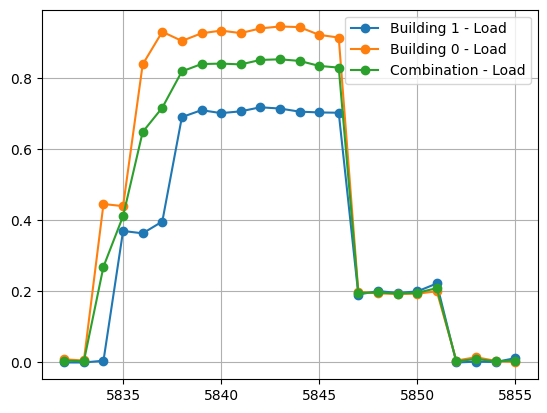

In [84]:
# Compare in a plot the convex combination of the predictions with the prediction of the convex combination for a given day

day_index = 5832
building_index = 1

b1, b2 = combinations[building_index]

pred_1 = pred_files[b1]
pred_2 = pred_files[b2]

# Read the combination from csv

comb = pd.read_csv(f'data/naive_data/eval/pred_Building_{building_index + 1}.csv')

plt.plot(pred_1['non_shiftable_load_4h'][day_index:day_index + 24], label=f'Building {b1} - Load', marker='o')
plt.plot(pred_2['non_shiftable_load_4h'][day_index:day_index + 24], label=f'Building {b2} - Load', marker='o')
plt.plot(comb['non_shiftable_load_4h'][day_index:day_index + 24], label='Combination - Load', marker='o')

plt.legend()
plt.grid()
plt.show()

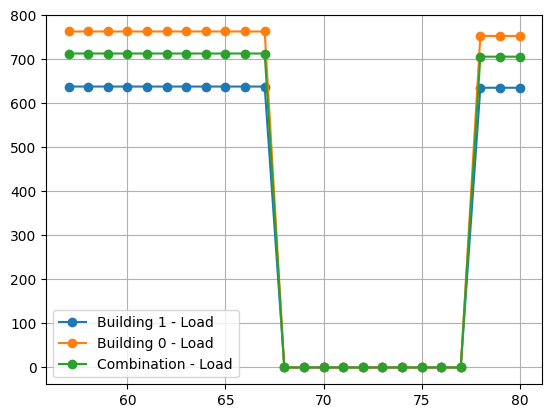

In [85]:
# Compare in a plot the convex combination of the buildings with the building of the convex combination for a given day

day_index = 57

b1, b2 = combinations[building_index]

building_1 = building_files[b1]
building_2 = building_files[b2]

# Read the combination from csv

comb = pd.read_csv(f'data/naive_data/eval/Building_{building_index + 1}.csv')

plt.plot(building_1['solar_generation'][day_index:day_index + 24], label=f'Building {b1} - Load', marker='o')
plt.plot(building_2['solar_generation'][day_index:day_index + 24], label=f'Building {b2} - Load', marker='o')
plt.plot(comb['solar_generation'][day_index:day_index + 24], label='Combination - Load', marker='o')

plt.legend()
plt.grid()
plt.show()

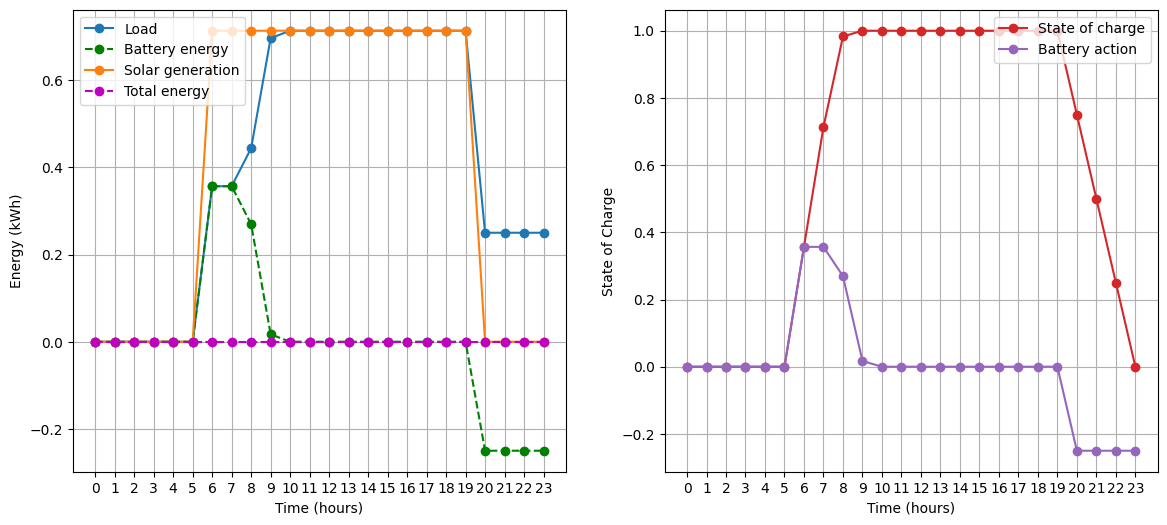

In [86]:
# Check data generated picking random days from random buildings

day_index = 48
building_index = 0

comb = pd.read_csv(f'data/naive_data/eval/Building_{building_index + 1}.csv')
sol = pd.read_csv(f'data/naive_data/eval/sol_Building_{building_index + 1}.csv')

plot_energy_solution({
    'load': comb['non_shiftable_load'].values[day_index:day_index + 24],
    'batt': sol['batt'].values[day_index:day_index + 24],
    'soc': sol['soc'].values[day_index:day_index + 24],
    'action': sol['action'].values[day_index:day_index + 24],
}, comb['solar_generation'].values[day_index:day_index + 24] / 1000)

In [87]:
pd.read_csv(f'data/naive_data/sol_{building_name}.csv').head(24)

,batt,soc,action
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.315594,0.315594,0.315594
7,0.315594,0.631188,0.315594
8,0.315594,0.946781,0.315594
9,0.053219,1.000000,0.053219


In [88]:
sol['soc'].values[day_index:day_index + 24]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.35670916, 0.71341832, 0.98299998, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.75      , 0.5       , 0.25      , 0.        ])

In [89]:
sol['batt'].values[day_index:day_index + 24]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.35670916,  0.35670916,  0.26958166,  0.01700002,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.25      , -0.25      , -0.25      , -0.25      ])

In [90]:
comb['non_shiftable_load'].values[day_index:day_index + 24]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.35670916, 0.35670916, 0.44383666, 0.6964183 ,
       0.71341832, 0.71341832, 0.71341832, 0.71341832, 0.71341832,
       0.71341832, 0.71341832, 0.71341832, 0.71341832, 0.71341832,
       0.25      , 0.25      , 0.25      , 0.25      ])

In [91]:
comb['solar_generation'].values[day_index:day_index + 24] / 1000

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.71341832, 0.71341832, 0.71341832, 0.71341832,
       0.71341832, 0.71341832, 0.71341832, 0.71341832, 0.71341832,
       0.71341832, 0.71341832, 0.71341832, 0.71341832, 0.71341832,
       0.        , 0.        , 0.        , 0.        ])